# Load Needed Packages

#### Note: if you want to change precision or device of JAX, the best way to do it is to follow (as an example)
#### `conda activate <your env name>`
#### `conda env config vars set JAX_ENABLE_X64=True`
#### `conda env config vars set jax_platform_name=cpu`
#### `conda activate <your env name>`
#### Make sure to restart VScode or jupyter notebook after this! `jax.config.update("jax_enable_x64", False)` may or may not work because I define default jax arrays in my python codes.

In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jar
from pandora import nf_dist
# jax.config.update('jax_platform_name', 'cuda')
# jax.config.update("jax_enable_x64", False)
import torch
import numpy as np
from scipy.stats import norm
from pandora import models, utils, GWBFunctions
from pandora import LikelihoodCalculator as LC
from enterprise_extensions.model_utils import get_tspan
import pickle, json, os, corner, glob, random, copy, time, inspect
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import matplotlib.lines as mlines

import torch.utils.dlpack as td
import jax.dlpack as jd

plt.style.use('dark_background')
hist_settings = dict(
    bins = 40,
    histtype = 'step',
    lw = 3,
    density = True
)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
# %load_ext line_profiler

/home/koonima/anaconda3/envs/pandora/lib/python3.11/site-packages/pandora/GWBFunctions.py:11: UserWarning: The package `interpax` is needed for spline interpolation of ORF.
  warnings.warn("The package `interpax` is needed for spline interpolation of ORF.")


Optional mpi4py package is not installed.  MPI support is not available.


# Choose a data set

In [ ]:
datadir = ...
with open(datadir + f'v1p1_de440_pint_bipm2019.pkl', 'rb') as fin:
    psrs = pickle.load(fin)
psrlist = [psr.name for psr in psrs]
with open(datadir + f'v1p1_all_dict.json', 'r') as fin:
    noise_dict = json.load(fin)
inc_ecorr = True
backend = 'backend'
tnequad = False

libstempo not installed. Will use PINT instead.


# Step 1: Model Construction for GWB

## Frequency-bins

In [28]:
Tspan = get_tspan(psrs) # The time-span of the entire PTA
crn_bins = 5 # number of frequency-bins for the GWB
int_bins = 30 # number of frequency-bins for the non-GWB (IRN) red noise
assert int_bins > crn_bins
f_intrin = jnp.arange(1/Tspan, (int_bins + 0.01)/Tspan, 1/Tspan) # an array of frequency-bins for the IRN process
f_common = f_intrin[:crn_bins] # an array of frequency-bins for the common process
renorm_const = 1 # the factor by which the units are going to change (divided by). Set it to `1` for no unit change (seconds), or let it be `1e9` (nano seconds) for better performance.

## GWB PSD model

### A dictionary is used to store the necessary information about GWB PSD. You can either use the `utils.param_order_help` to make your own dictionary or use one of the pre-made ones. Take a look at `GWBFunctions.py` for a list of supported PSD as well as GWB ORF functions.

### For example, choose a GWB with HD correlations and fixed spectral index (at 13/3) powerlaw PSD.

In [29]:
# chosen_psd_model, chosen_orf_model, gwb_helper_dictionary = utils.fixed_gamma_hd_pl(renorm_const=renorm_const, lower_amp=-16.0, upper_amp=-13.0)
chosen_psd_model, chosen_orf_model, gwb_helper_dictionary = utils.hd_spectrum(renorm_const=renorm_const,crn_bins=crn_bins, lower_halflog10_rho=-9, upper_halflog10_rho=-3.5)
# chosen_psd_model, chosen_orf_model, gwb_helper_dictionary = utils.varied_gamma_hd_pl(renorm_const=renorm_const)
# chosen_psd_model, chosen_orf_model, gwb_helper_dictionary = utils.varied_gamma_gt_pl(renorm_const=renorm_const)
# chosen_psd_model, chosen_orf_model, gwb_helper_dictionary = utils.varied_gamma_bin_orf_pl(renorm_const=renorm_const)
gwb_helper_dictionary

{'ordered_gwb_psd_model_params': array(['halflog10_rho'], dtype='<U13'),
 'varied_gwb_psd_params': [np.str_('halflog10_rho')],
 'gwb_psd_param_lower_lim': Array([-9., -9., -9., -9., -9.], dtype=float32),
 'gwb_psd_param_upper_lim': Array([-3.5, -3.5, -3.5, -3.5, -3.5], dtype=float32)}

### Now, construct the model using `models.UniformPrior`

In [30]:
help(models.UniformPrior)

Help on class UniformPrior in module pandora.models:

class UniformPrior(builtins.object)
 |  UniformPrior(gwb_psd_func, orf_func, crn_bins, int_bins, f_common, f_intrin, df, psr_pos, Tspan, Npulsars, gwb_helper_dictionary, gamma_min=0, gamma_max=7, log10A_min=Array(-13.5, dtype=float32), log10A_max=Array(-6.5, dtype=float32), renorm_const=1000000000.0)
 |  
 |  A class to take care of prior and the phi-matrix construction based on uniform/log-uniform priors.
 |  
 |  :param gwb_psd_func: a PSD function from the `GWBFunctions` class
 |  :param orf_func: an orf function from the `GWBFunctions` class
 |  :param crn_bins: number of frequency-bins for the GWB
 |  :param int_bins: number of frequency-bins for the non-GWB (IRN) red noise
 |  :param `f_common`: an array of frequency-bins for the common process
 |  :param `f_intrin`: an array of frequency-bins for the IRN process
 |  :param df: the diffence between consecutive frequency-bins. It is usually 1/Tspan
 |  :param psr_pos: an array 

In [31]:
o = models.UniformPrior(gwb_psd_func = chosen_psd_model,
                orf_func = chosen_orf_model,
                crn_bins = crn_bins,
                int_bins = int_bins,
                f_common = f_common, 
                f_intrin = f_intrin,
                df = 1/Tspan,
                Tspan = Tspan, 
                Npulsars = len(psrs),
                psr_pos = [psr.pos for psr in psrs],
                gwb_helper_dictionary = gwb_helper_dictionary,
                gamma_min = 0,
                gamma_max = 7,
                log10A_min = -20 + 0.5 * jnp.log10(renorm_const), #`0.5 * jnp.log10(renorm_const)` is added to account for change in units,
                log10A_max = -11 + 0.5 * jnp.log10(renorm_const), #`0.5 * jnp.log10(renorm_const)` is added to account for change in units,
                renorm_const = renorm_const)

In [32]:
x0 = o.make_initial_guess(key = jar.key(100)) # Some random draw from the prior given an RNG key

In [33]:
x0[-5:]

Array([-3.7230034, -7.468546 , -7.1080923, -8.310389 , -4.211921 ],      dtype=float32)

In [25]:
phimat = o.get_phi_mat(x0)
phimat.shape

(30, 67, 67)

### Here is the phi-matrix. Note that this matrix is batched by `max(int_bins, crn_bins)` and is lower-triangular as fully populating phi (a positive definite matrix) is vain for computational purposes!

In [26]:
phimat[0]

Array([[ 3.58090973e+01,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.37972431e+01,  3.59453621e+01,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.03641949e+01,  1.63615341e+01,  5.93635498e+02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-3.64994168e+00,  4.78269994e-01,  3.24745464e+00, ...,
         5.12239281e+05,  0.00000000e+00,  0.00000000e+00],
       [-3.76804495e+00, -9.62294817e-01,  1.02372199e-01, ...,
         7.48983955e+00,  3.58090935e+01,  0.00000000e+00],
       [-3.94268322e+00, -8.76233101e-01,  5.53238273e-01, ...,
         1.01808195e+01,  1.69072742e+01,  1.21475332e+04]],      dtype=float32)

# Step 2: Likelihood Calculation and Addition of Astro Parameters

In [11]:
help(LC.AstroInferenceModel)

Help on class AstroInferenceModel in module pandora.LikelihoodCalculator:

class AstroInferenceModel(builtins.object)
 |  AstroInferenceModel(nf_dist, num_astro_params, astr_prior_lower_lim, astr_prior_upper_lim, astro_additional_prior_func, run_type_object, psrs, TNr=Array([False], dtype=bool), TNT=Array([False], dtype=bool), noise_dict=None, backend='none', tnequad=False, inc_ecorr=False, del_pta_after_init=True, matrix_stabilization=True)
 |  
 |  A class to calculate likelihood based on a given IRN + GWB model (no deterministic signal) as well as as a normalizing flow astroemulator
 |  
 |  :param nf_dist: the normalizing flow object
 |  :param num_astro_params: the number of astro parameters 
 |  :param astr_prior_lower_lim: the lower bound for the astro parameters
 |  :param astr_prior_upper_lim: the upper bound for the astro parameters
 |  :param astro_additional_prior_func: if you want non-uniform prior on the astro parameters, supply a numpy-compatible function to calculate
 |

### Making the AstroInference object is easy. In addition to your normalzing flow object, you need to define your prior function for the astro-parameters. For example:

In [12]:
def astro_prior_func_uniform(xs):
    '''
    this function does not do anything. Uniform prior is already included in the Bayesian inference object. 
    So, if you wish to use uniform prior on the astro parameters, this function is what you need.

    :param xs: an array of length equal to the number of astro params
    '''
    return 0

#mean = np.array([...])
#std = np.array([...])
def astro_additional_prior_func_normal(xs):
    '''
    this function is for the inclusion of the normal priors. You can change it to a multi-variate normal if needed.
    just choose your mean and std for the astro parameters. BE CAREFUL! The order of `xs` is the same order as your 
    trained normalizing flow object.

    :param xs: an array of length equal to the number of astro params
    '''
    return norm.logpdf(xs, loc=mean, scale=std)

In [13]:
astro_prior_bounds = np.array([[0.1, 11.0], 
          [-3.5, -1.5], 
          [10.5, 12.5], 
          [7.6, 9.0], 
          [0.0, 0.9], 
          [-1.5, 0.0]])

astro_x0 = np.random.uniform( 
            astro_prior_bounds[:, 0], 
            astro_prior_bounds[:, 1])[None]
astro_x0, astro_x0.shape

(array([[ 6.30619759, -3.29260419, 11.76121006,  8.34958901,  0.20050753,
         -0.79427605]]),
 (1, 6))

### Load your normalizing flow object

In [14]:
nf, half_range, B, mean, _, _ = torch.load('../data/condflow.pkl', weights_only = False,
                                            map_location = 'cpu')

/home/koonima/anaconda3/envs/pandora/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Specify the number of astro parameters

In [15]:
n_astro_params = 6

In [16]:
nf_dist_object = nf_dist.NFastroinference(pyro_nf_object = nf,
        mean = np.array(mean),
        half_range = np.array(half_range),
        scale = B,
        gwb_freq_idxs = np.array(range(n_astro_params, n_astro_params + crn_bins), dtype = int),
        ast_param_idxs = np.array(range(n_astro_params), dtype = int))

### Make the AstroInference object

In [17]:
m = LC.AstroInferenceModel(psrs = psrs,
                        nf_dist = nf_dist_object ,
                        num_astro_params = n_astro_params,
                        astr_prior_lower_lim = astro_prior_bounds[:, 0],
                        astr_prior_upper_lim = astro_prior_bounds[:, 1],
                        astro_additional_prior_func = astro_prior_func_uniform,
                        TNr=jnp.array([False]),
                        TNT=jnp.array([False]),
                        run_type_object = o,
                        noise_dict = noise_dict, 
                        backend = 'backend', 
                        tnequad = False, 
                        inc_ecorr = True, 
                        del_pta_after_init = True,
                        matrix_stabilization = True)

Package `fastshermanmorrison` not installed. Fallback to sherman-morrison


The delta is 1e-06
Condition number of the TNT matrix before stabilizing is: 6.524224e+18
Condition number of the TNT matrix after stabilizing is: 1.0054233e+17


### It is VERY important that the initial guess of the model parameters `x0` leads to a finite likelihood! Keep generating new `x0` until the likelihood is finite


In [ ]:
for _ in range(10000, 10000 + 50):
    x0 = m.make_initial_guess(seed = _)
    ans = m.get_lnliklihood(x0)
    # assert np.isfinite(ans)
    print(_, ans)

In [21]:
m.get_lnliklihood(x0)

array([39315.48], dtype=float32)

In [22]:
%timeit m.get_lnliklihood(x0)

13 ms ± 679 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Now perform sampling... 

In [23]:
m.sample(x0 = x0, niter = int(4e6), savedir = '../testnew/AstroInference/', resume=False)

Finished 0.25 percent in 102.994586 s Acceptance rate = 0.36573Adding DE jump with weight 50
Finished 99.98 percent in 30165.021440 s Acceptance rate = 0.242391
Run Complete


# Postprocessing

In [24]:
plt.style.use('default')
def figsize(scale, wc = 1, hc = 1):
    fig_width_pt = 513.17 #469.755                  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [wc * fig_width,hc * fig_height]
    return fig_size
plt.rcParams.update(plt.rcParamsDefault)

params = {#'backend': 'pdf',
        'axes.labelsize': 12,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        "xtick.top": True,
        "ytick.right": True,
        "xtick.minor.visible": True,
        "xtick.major.top": True, 
        "xtick.minor.top": True,
        "ytick.minor.visible": True, 
        "ytick.major.right": True, 
        "ytick.minor.right": True,
        "ytick.direction": "in",
        "xtick.direction": "in",
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        'font.serif':'Times',
        "text.usetex": True,
        #'text.latex.preamble': [r'\usepackage{amsmath}'],
        'text.usetex':True,
        'figure.figsize': figsize(0.5, 1, 1)}
plt.rcParams.update(params)

In [25]:
chain = np.loadtxt('../testnew/AstroInference/chain_1.txt')
burn = int(0.25 * chain.shape[0])
chain = chain[burn:, :-4]
chain.shape

(299925, 145)

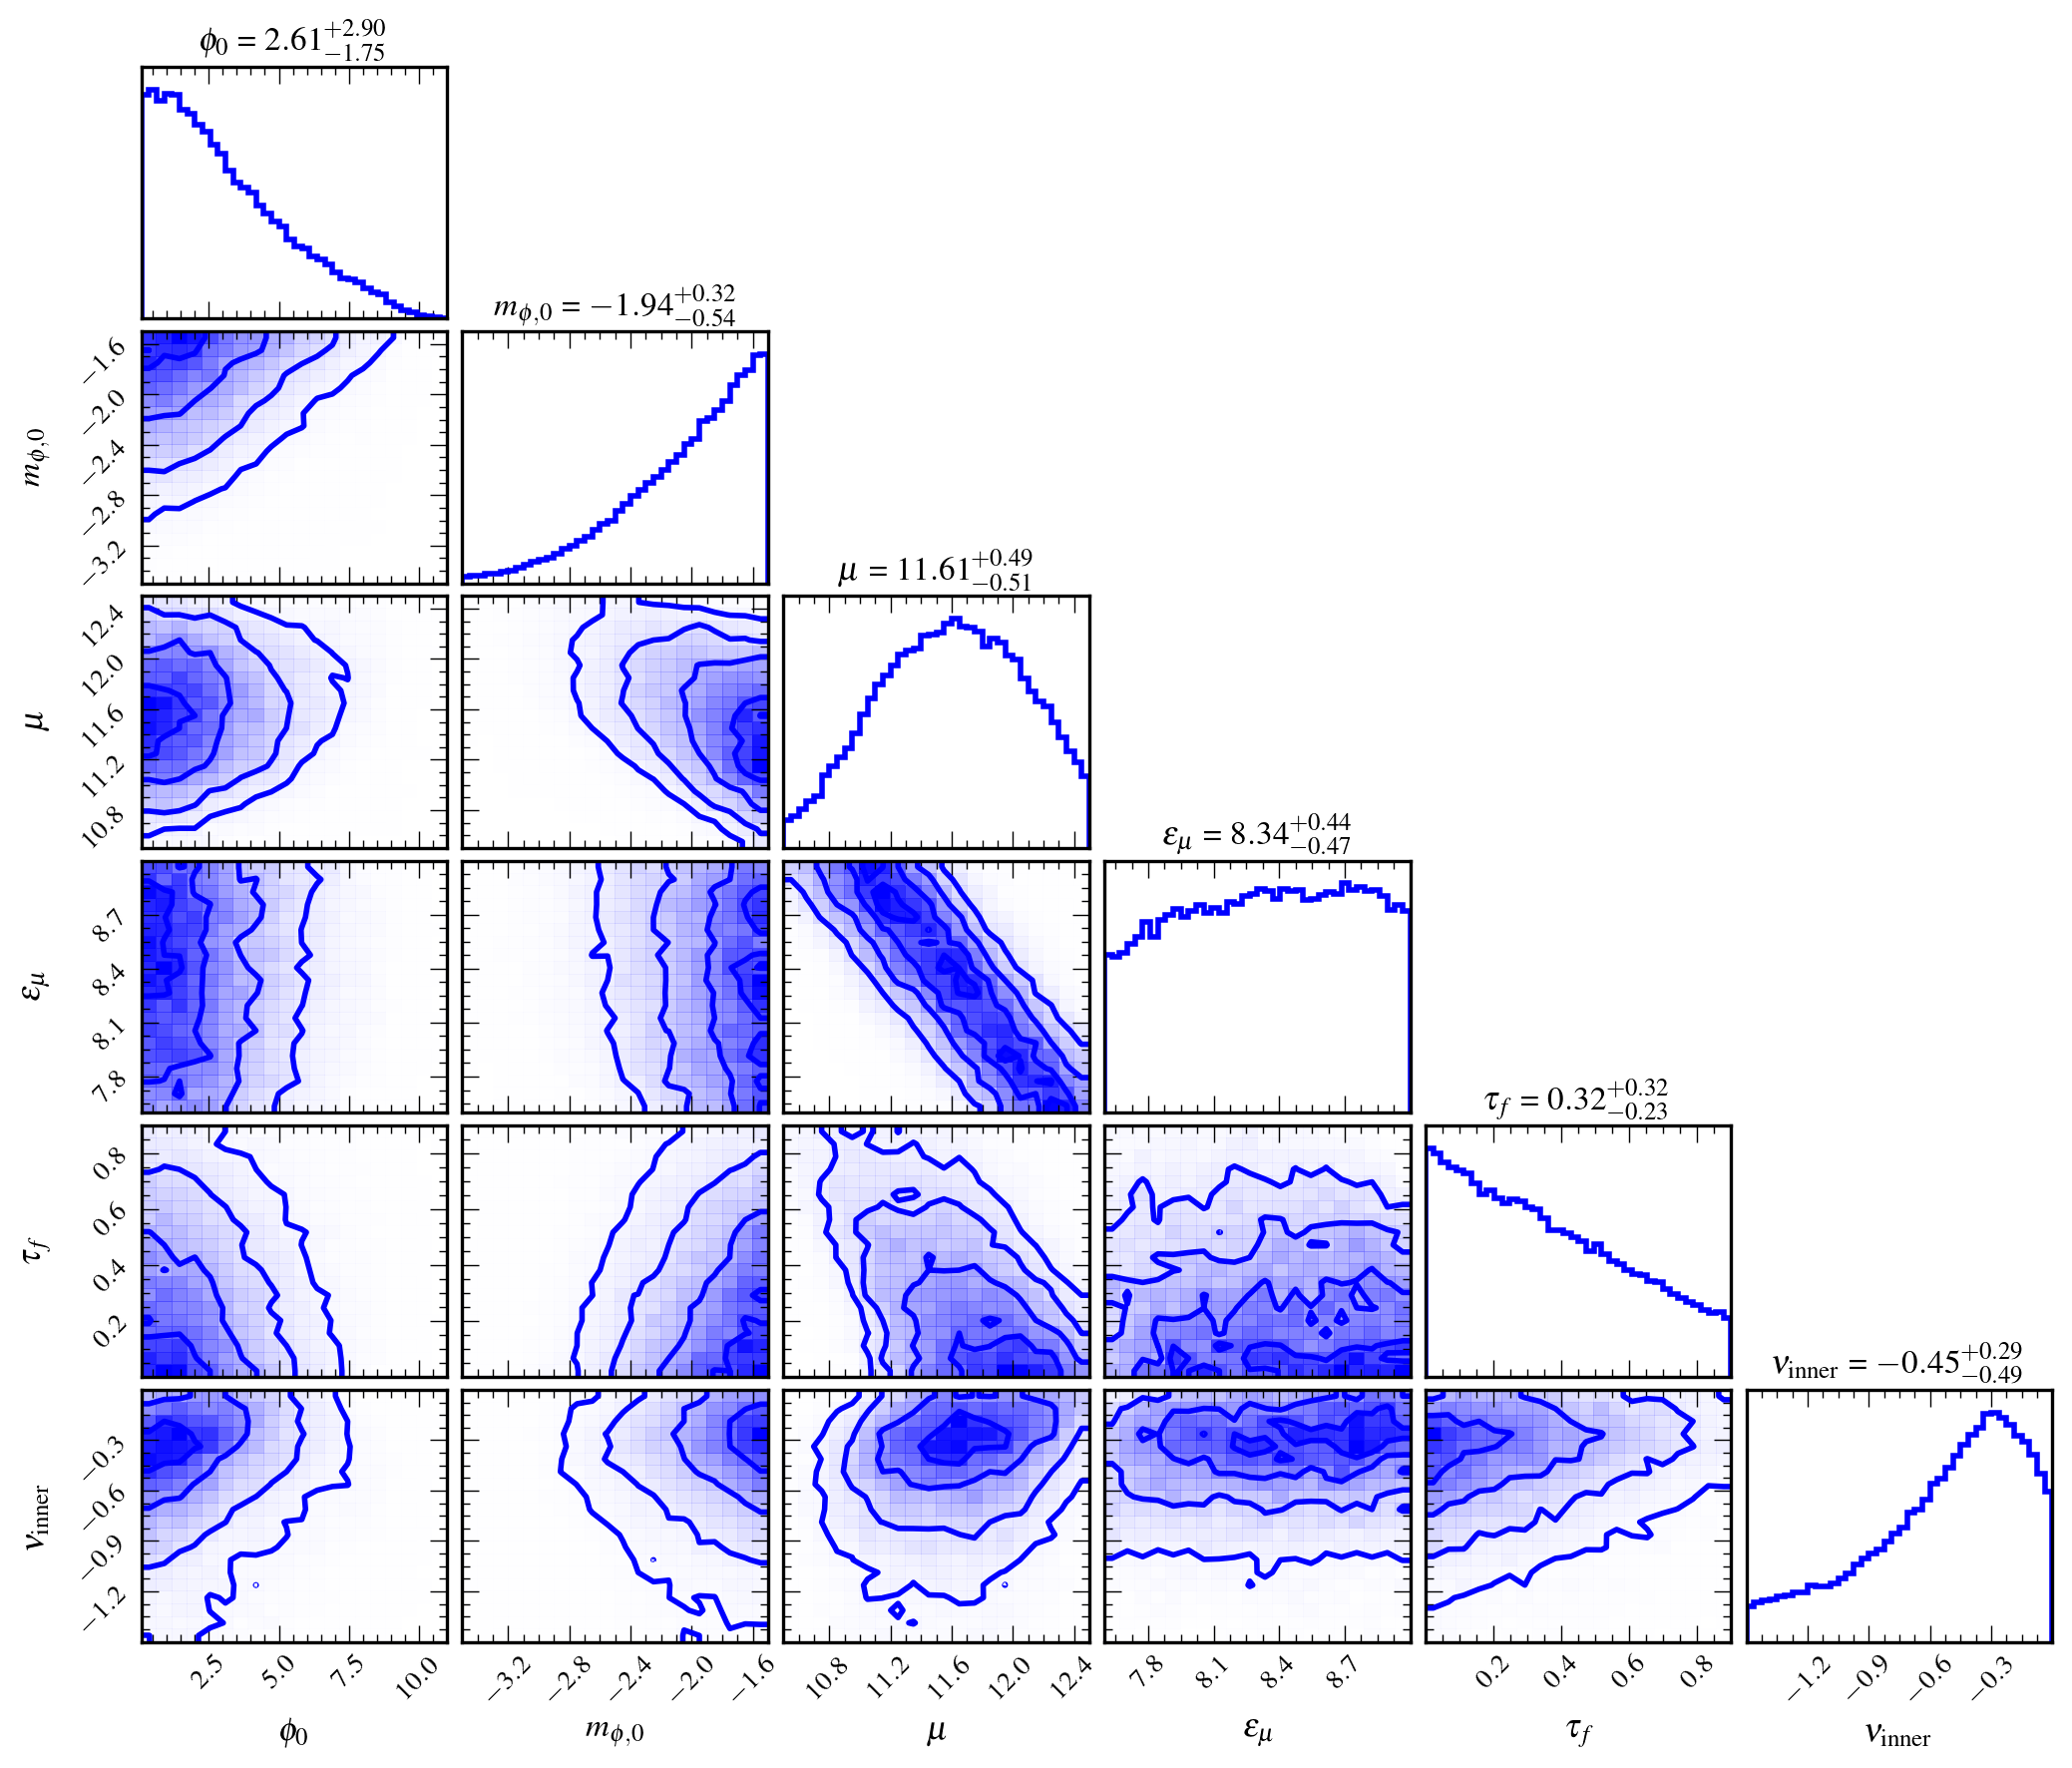

In [26]:
labels = [r'$\phi_{0}$', r'$m_{\phi,0}$', r'$\mu$', r'$\epsilon_{\mu}$', r'$\tau_f$', r'$\nu_{\rm{inner}}$']
fig = plt.figure(figsize=figsize(0.5, 3, 4))
fig = corner.corner(chain[:, -6:], fig = fig, color='blue', bins=20, hist_bin_factor=2, data_kwargs={'ms':3}, hist_kwargs={'density': True, 'lw':2}, 
                    contour_kwargs={'linewidths':2}, labels = labels,show_titles = True,
            truth_color = 'red', desity = True, plot_datapoints = False)
plt.show()

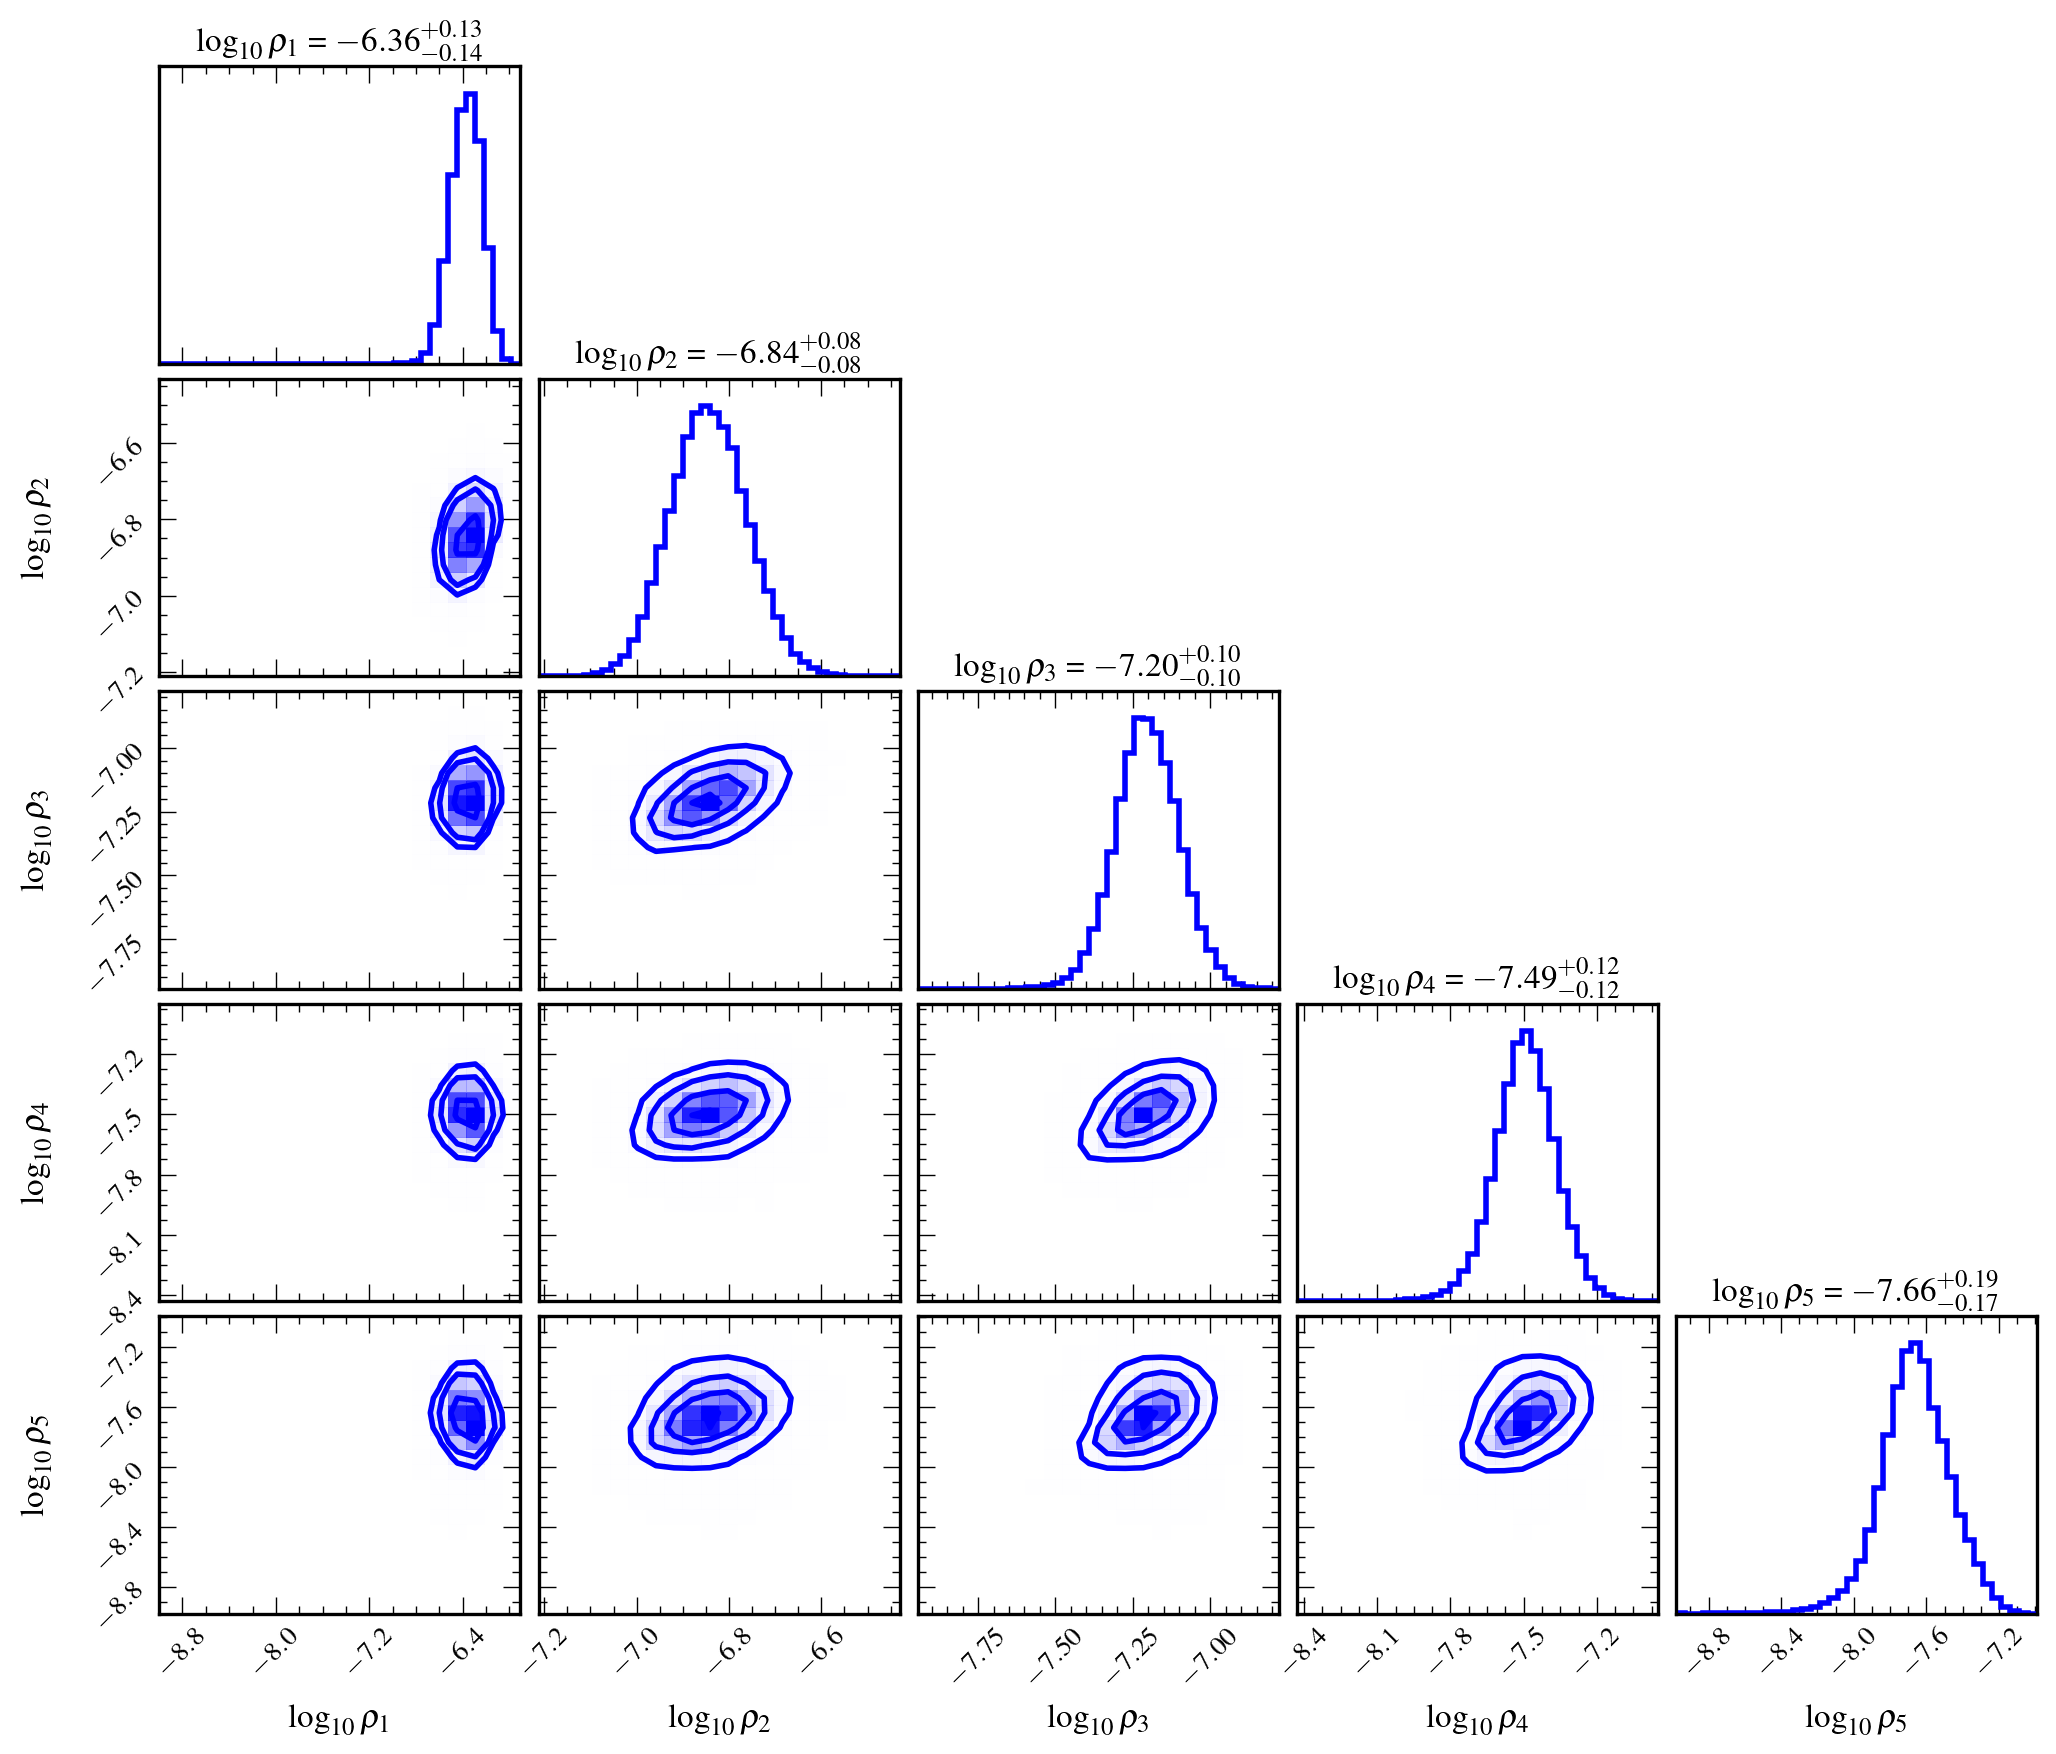

In [27]:
labels = [r'$\log_{{{0}}}\rho_{{{1}}}$'.format(10, _+1) for _ in range(5)]
fig = plt.figure(figsize=figsize(0.5, 3, 4))
fig = corner.corner(chain[:, -11:-6] - 0.5 * np.log10(renorm_const), fig = fig, color='blue', bins=20, hist_bin_factor=2, data_kwargs={'ms':3}, hist_kwargs={'density': True, 'lw':2}, 
                    contour_kwargs={'linewidths':2}, labels = labels,show_titles = True,
            truth_color = 'red', desity = True, plot_datapoints = False)
plt.show()